# 시뮬레이션 데이터 생성 코드

In [40]:
   """
    전처리가 필요한 원본 A/B 테스트 데이터를 생성합니다.
    - 정확한 트래픽 비율(기본 50:50)과 재현성(seed)을 지원
    - 비구매(0)와 결제중 이탈(NaN)을 구분하고, 보조 플래그 컬럼 제공
    - 타임스탬프 기준 시간(now) 외부 주입 가능
    """
#import
import pandas as pd
import numpy as np
import datetime as dt

# 1) 변수 초기화
#session, 트래픽 비율, seed 초기화
def generate_raw_data(
    num_sessions: int = 100000,
    traffic_ratio=(0.5, 0.5),
    seed: int | None = 42,
    now: dt.datetime | None = None,
):

    # 난수생성 및 시간 설정
    rng = np.random.default_rng(seed)
    if now is None:
        now = dt.datetime.now()

    # 그룹별 행동 확률/파라미터
    """
    A - 현재 추석선물에 큐레이션 유지 그룹
    B - ( #감사한 분들께 , #부모님들께) 등과 같은 큐레이션을 넣은 그룹
    """
    params = {
        'A': {'click_proba': 0.15, 'buy_proba': 0.025, 'bounce_proba': 0.35, 'aov': 68000},
        'B': {'click_proba': 0.25, 'buy_proba': 0.031, 'bounce_proba': 0.29, 'aov': 71500}
    }

    # 정확한 트래픽 비율로 그룹 리스트 생성 후 셔플
    nA = int(num_sessions * traffic_ratio[0])
    nB = num_sessions - nA
    groups = np.array(['A'] * nA + ['B'] * nB)
    rng.shuffle(groups)

    # 최근 2주 각 사용자의 접속시간 접속기기 데이터 생성
    max_minutes = 14 * 24 * 60
    minute_offsets = rng.integers(0, max_minutes, size=num_sessions)
    timestamps = np.array([now - dt.timedelta(minutes=int(m)) for m in minute_offsets])

    devices = rng.choice(['mobile', 'desktop'], size=num_sessions, p=[0.8, 0.2])

    # 결과 컨테이너
    session_ids = [f'session_{i}' for i in range(num_sessions)]
    page_views = np.empty(num_sessions, dtype=int)
    clicked_curation = np.zeros(num_sessions, dtype=int)
    purchase_amount = np.zeros(num_sessions, dtype=float)
    purchased_flag = np.zeros(num_sessions, dtype=int)
    abandoned_at_payment = np.zeros(num_sessions, dtype=int)

    # 2) 데이터 생성
    for i in range(num_sessions):
        g = groups[i]
        p = params[g]

        # 이탈 여부
        is_bounce = rng.random() < p['bounce_proba']
        if is_bounce:
            page_views[i] = 1
            clicked_curation[i] = 0
            # purchase_amount[i] already 0.0
            continue

        # 비이탈 세션: 페이지뷰 랜덤(2~9)
        page_views[i] = rng.integers(2, 10)

        # 클릭
        clicked_curation[i] = 1 if rng.random() < p['click_proba'] else 0

        # 구매
        if rng.random() < p['buy_proba']:
            # 결제 중 이탈(결측)
            if rng.random() < 0.1:
                purchase_amount[i] = np.nan
                abandoned_at_payment[i] = 1
            else:
                amt = rng.normal(loc=p['aov'], scale=15000)
                amt = max(10_000, amt)
                purchase_amount[i] = round(amt)  # 원 단위 정수
                purchased_flag[i] = 1
        # else: remain 0.0

    df = pd.DataFrame({
        'session_id': session_ids,
        'timestamp': timestamps,
        'user_group': groups,
        'device': devices,
        'page_views': page_views,
        'clicked_curation': clicked_curation,
        'purchase_amount': purchase_amount,  # 0=비구매, NaN=결제중 이탈, >0=구매성공
        'purchased_flag': purchased_flag,    # 명시적 구매 성공 여부
        'abandoned_at_payment': abandoned_at_payment,  # 결제 단계 이탈(결측 발생)
    })

    return df

# 3) 파일 저장 실행
generate_raw_data()
df = generate_raw_data()
df.to_csv('curation_ab_test.csv', index=False)
df

,session_id,timestamp,user_group,device,page_views,clicked_curation,purchase_amount,purchased_flag,abandoned_at_payment
0,session_0,2025-09-15 08:00:04.638476,A,desktop,1,0,0.0,0,0
1,session_1,2025-09-20 00:29:04.638476,A,desktop,1,0,0.0,0,0
2,session_2,2025-09-18 19:38:04.638476,A,mobile,1,0,0.0,0,0
3,session_3,2025-09-23 01:13:04.638476,B,mobile,5,0,0.0,0,0
4,session_4,2025-09-15 18:11:04.638476,B,mobile,3,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...
99995,session_99995,2025-09-14 01:33:04.638476,A,mobile,1,0,0.0,0,0
99996,session_99996,2025-09-17 18:42:04.638476,B,mobile,7,0,0.0,0,0
99997,session_99997,2025-09-17 16:25:04.638476,A,mobile,1,0,0.0,0,0
99998,session_99998,2025-09-14 05:59:04.638476,A,mobile,1,0,0.0,0,0


# 전처리 및 테스트 실행 코드

In [41]:
import pandas as pd
import numpy as np

# 1) 로드
try:
    df = pd.read_csv('curation_ab_test.csv')

except FileNotFoundError:
    raise SystemExit("Error: 'curation_ab_test.csv' 파일을 찾을 수 없습니다. 먼저 데이터 생성 코드를 실행해주세요.")

print("\n====== 1. 데이터 전처리 과정 ======")
print("\n[초기 데이터 정보]")
print(df.info())

# 2) 전처리
# timestamp: 필요 시 utc=True 고려
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# 금액 컬럼을 수치로 강제(혹시 문자열로 저장된 경우 대비)
df['purchase_amount'] = pd.to_numeric(df['purchase_amount'], errors='coerce')

# (중요) 결제 단계 이탈 플래그 먼저 생성 (NaN 보존)
df['abandoned_at_payment'] = df['purchase_amount'].isna()

# 구매 성공 플래그: NaN(결제이탈)은 False, 금액>0인 경우만 True
df['converted'] = (df['purchase_amount'].fillna(0) > 0)

# 보고/집계용: 금액 NaN은 0으로 채움(비구매/이탈 구분은 위 플래그로 유지)
df['purchase_amount_filled'] = df['purchase_amount'].fillna(0)

print("\n결제이탈 플래그('abandoned_at_payment')를 만든 뒤, 금액만 0으로 채웠습니다.")
print("\n전처리 후 df ")
print(df.info())


# 3) 지표 계산 함수 (수치형 반환 + 표시용 포맷 분리)
def metrics_numeric(df):
    total = len(df)
    bounced = (df['page_views'] == 1).sum()
    bounce_rate = bounced / total if total else 0.0

    # CTR: 이탈 제외 세션을 분모로 정의
    active = df['page_views'] > 1
    ctr = df.loc[active, 'clicked_curation'].mean() if active.any() else 0.0

    cvr = df['converted'].mean() if total else 0.0

    # 구매자만 AOV
    purchasers = df['converted']
    aov = df.loc[purchasers, 'purchase_amount_filled'].mean() if purchasers.any() else 0.0

    # 결제단계 이탈 비율(참고)
    ap_rate = df['abandoned_at_payment'].mean() if total else 0.0

    return {
        'total': total,
        'bounce_rate': bounce_rate,    # 비율(0~1)
        'ctr': ctr,                    # 비율(0~1)
        'cvr': cvr,                    # 비율(0~1)
        'aov': aov,                    # 원
        'abandon_at_payment_rate': ap_rate # 비율(0~1)
    }

def metrics_table_row(name, m):
    return {
        '그룹': name,
        '총 방문자': m['total'],
        '페이지 이탈률': f"{m['bounce_rate']*100:.2f}%",
        '큐레이션 클릭률 (CTR)': f"{m['ctr']*100:.2f}%",
        '구매 전환율 (CVR)': f"{m['cvr']*100:.2f}%",
        '평균 주문 금액 (AOV)': f"{int(round(m['aov'])):,}원",
        '결제단계 이탈율': f"{m['abandon_at_payment_rate']*100:.2f}%"
    }

# 그룹별 계산
grouped = {g: d for g, d in df.groupby('user_group')}
m_a = metrics_numeric(grouped.get('A', pd.DataFrame()))
m_b = metrics_numeric(grouped.get('B', pd.DataFrame()))

summary_df = pd.DataFrame([
    metrics_table_row('A그룹 (기존)', m_a),
    metrics_table_row('B그룹 (신규)', m_b),
]).set_index('그룹').T

print("\n====== 2. 최종 A/B 테스트 결과 요약 ======")
print(summary_df)

# 4) (선택) 간단한 비율 차 신뢰구간 예시: CVR 차이 95% CI (정규 근사)
def diff_prop_ci(p1, n1, p2, n2, alpha=0.05):
    # Wald CI
    import math
    diff = p2 - p1
    se = math.sqrt(p1*(1-p1)/n1 + p2*(1-p2)/n2)
    z = 1.96  # 95%
    return diff, (diff - z*se, diff + z*se)

p1, n1 = m_a['cvr'], m_a['total']
p2, n2 = m_b['cvr'], m_b['total']
if n1 > 0 and n2 > 0:
    diff, (lo, hi) = diff_prop_ci(p1, n1, p2, n2)
    print("\n[참고] CVR 차이 (B - A) 95% CI")
    print(f"차이: {diff*100:.2f}p,  신뢰구간: [{lo*100:.2f}p, {hi*100:.2f}p]")



====== 1. 데이터 전처리 과정 ======

[초기 데이터 정보]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   session_id            100000 non-null  object 
 1   timestamp             100000 non-null  object 
 2   user_group            100000 non-null  object 
 3   device                100000 non-null  object 
 4   page_views            100000 non-null  int64  
 5   clicked_curation      100000 non-null  int64  
 6   purchase_amount       99818 non-null   float64
 7   purchased_flag        100000 non-null  int64  
 8   abandoned_at_payment  100000 non-null  int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 6.9+ MB
None

결제이탈 플래그('abandoned_at_payment')를 만든 뒤, 금액만 0으로 채웠습니다.

전처리 후 df 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column                  Non-

In [42]:
import pandas as pd
import numpy as np

# 1) 로드
try:
    df = pd.read_csv('raw_ab_test_data.csv')

except FileNotFoundError:
    raise SystemExit("Error: 'raw_ab_test_data.csv' 파일을 찾을 수 없습니다. 먼저 데이터 생성 코드를 실행해주세요.")

print("\n====== 1. 데이터 전처리 과정 ======")
print("\n[초기 데이터 정보]")
df.info()

# 2) 전처리
# timestamp: 필요 시 utc=True 고려
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# 금액 컬럼을 수치로 강제(혹시 문자열로 저장된 경우 대비)
df['purchase_amount'] = pd.to_numeric(df['purchase_amount'], errors='coerce')

# (중요) 결제 단계 이탈 플래그 먼저 생성 (NaN 보존)
df['abandoned_at_payment'] = df['purchase_amount'].isna()

# 구매 성공 플래그: NaN(결제이탈)은 False, 금액>0인 경우만 True
df['converted'] = (df['purchase_amount'].fillna(0) > 0)

# 보고/집계용: 금액 NaN은 0으로 채움(비구매/이탈 구분은 위 플래그로 유지)
df['purchase_amount_filled'] = df['purchase_amount'].fillna(0)

# === 0) 유틸 ===
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

def format_pct(x):
    return f"{x*100:.2f}%"

def holm_bonferroni(pvals, alpha=0.05):
    # 반환: 보정 후 유의(각 지표별 True/False)
    m = len(pvals)
    order = np.argsort(pvals)
    passed = [False]*m
    for k, idx in enumerate(order, start=1):
        if pvals[idx] <= alpha/(m-k+1):
            passed[idx] = True
        else:
            # 이후는 모두 False
            break
    return passed

# 3) 유틸
df['exposed'] = 1  # 노출된 모든 세션
df['clicked'] = (df['clicked_curation'] == 1).astype(int)  # 큐레이션 클릭 여부 → CTR 계산용.
df['purchased'] = df['converted'].astype(int)  #구매 전환 여부 → CVR 계산용
df['revenue'] = df['purchase_amount_filled']  # NaN->0 처리된 금액
df['bounced'] = (df['page_views'] == 1).astype(int)

# 결제단계 이탈: 가능하면 별도 이벤트 기반 권장. 현재 데이터 기준:
df['abandon_pay'] = df['abandoned_at_payment'].astype(int) if 'abandoned_at_payment' in df.columns else 0

def agg(group):
    n = len(group)
    return pd.Series({
        'sessions': n,
        'ctr': group['clicked'].sum()/n if n else 0.0,
        'cvr': group['purchased'].sum()/n if n else 0.0,
        'bounce': group['bounced'].sum()/n if n else 0.0,
        'abandon_pay': group['abandon_pay'].sum()/n if n else 0.0,
        'aov': group.loc[group['purchased']==1, 'revenue'].mean() if group['purchased'].sum()>0 else 0.0,
        'rps': group['revenue'].sum()/n if n else 0.0,
        'clicks': group['clicked'].sum(),
        'purchases': group['purchased'].sum(),
        'revenue_sum': group['revenue'].sum()
    })

by = df.groupby('user_group').apply(agg)
A, B = by.loc['A'], by.loc['B']

def prop_report(success_A, n_A, success_B, n_B, metric_name):
    # A/B 그룹의 비율 차이가 통계적으로 유의미한지 확인
    stat, p = proportions_ztest([success_A, success_B], [n_A, n_B], alternative='two-sided')

    # Newcombe/Wilson CI (각 그룹) _ 성공률에 대한 신뢰구간을 계산
    ci_A = proportion_confint(success_A, n_A, method='wilson')
    ci_B = proportion_confint(success_B, n_B, method='wilson')

    #절대 리프트와 상대 리프트 계산
    lift_abs = (success_B/n_B) - (success_A/n_A)
    lift_rel = lift_abs / (success_A/n_A) if success_A>0 else np.nan
    return {
        'metric': metric_name,
        'A': success_A/n_A, 'A_CI_low': ci_A[0], 'A_CI_high': ci_A[1],
        'B': success_B/n_B, 'B_CI_low': ci_B[0], 'B_CI_high': ci_B[1],
        'diff(B-A)': lift_abs, 'rel_lift': lift_rel, 'p_value': p
    }
    """
    1) proportions_ztest) 하는 이유
    A/B 테스트를 통해 두 그룹이 차이가 나는지 확인하려면, 단순히 숫자를 비교하는 것만으로는 부족
    진짜 효과 때문인지, 단순 우연(샘플링 변동) 때문인지를 알 수 있어야 함.

    2) proportion_confint) 계산하는 이유
    p-value는 차이가 있는지 여부만 알려주고, 얼마나 차이가 나는지 알려주지 않음
    따라서 실제 성공률이 어느 범위 안에 있을 가능성이 높은지 확인
    예 - CTR 6% ± 1% → 실제 CTR은 5~7% 사이일 가능성이 높음
    + wilson 방법으로 안정적인 신뢰구간 사용 -> 샘플이 작거나 극단값이 있어도 범위 계산의 유리

    3) 리프트 계산 이유
       절대 리프트 - 단순히 B - A 차이를 계산한 값
       상대 리프트 - A 대비 B가 얼마나 비율상 증가했는지 확인
     """

rep_ctr = prop_report(int(A['clicks']), int(A['sessions']),
                      int(B['clicks']), int(B['sessions']), 'CTR')

rep_cvr = prop_report(int(A['purchases']), int(A['sessions']),
                      int(B['purchases']), int(B['sessions']), 'CVR')

rep_bounce = prop_report(int(A['bounce']*A['sessions']), int(A['sessions']),
                         int(B['bounce']*B['sessions']), int(B['sessions']), 'Bounce')

rep_abandon = prop_report(int(A['abandon_pay']*A['sessions']), int(A['sessions']),
                          int(B['abandon_pay']*B['sessions']), int(B['sessions']), 'Payment Abandon')

print("rep_ctr")
print(rep_ctr)



====== 1. 데이터 전처리 과정 ======

[초기 데이터 정보]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   session_id            100000 non-null  object 
 1   timestamp             100000 non-null  object 
 2   user_group            100000 non-null  object 
 3   device                100000 non-null  object 
 4   page_views            100000 non-null  int64  
 5   clicked_curation      100000 non-null  int64  
 6   purchase_amount       99818 non-null   float64
 7   purchased_flag        100000 non-null  int64  
 8   abandoned_at_payment  100000 non-null  int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 6.9+ MB
rep_ctr
{'metric': 'CTR', 'A': 0.09954, 'A_CI_low': 0.09694650210129514, 'A_CI_high': 0.10219502719543307, 'B': 0.17718, 'B_CI_low': 0.173858089953472, 'B_CI_high': 0.18055151022524699, 'diff(B-A)': 0.07764, 'rel_li

/tmp/ipython-input-1844405925.py:78: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  by = df.groupby('user_group').apply(agg)


# 1) 신뢰구간 (Confidence Interval)

A_CI_low, A_CI_high: 0.0893 ~ 0.1057

A그룹의 실제 CTR이 95% 확률로 이 범위 안에 있음

B_CI_low, B_CI_high: 0.1643 ~ 0.1854

B그룹의 실제 CTR이 95% 확률로 이 범위 안에 있음

즉, B그룹 CTR이 A그룹 범위를 완전히 벗어나므로, 단순 수치만 봐도 차이가 크다는 걸 시사합니다.


# 2) 절대 리프트 (diff(B-A))

diff(B-A): 0.0774 → 7.74%p 상승

실제 클릭률이 약 8%p 더 높아졌다는 뜻

KPI 기준으로 보면 A/B 중 B안이 명확히 클릭을 더 유도함

# 3) 상대 리프트 (rel_lift)

rel_lift: 0.7963 → 79.6% 상승

A 대비 B가 약 80% 더 클릭됐다는 상대적 효과

비율은 낮아도, 상대적 개선 효과가 큰 지표를 확인할 때 중요

# 4) 통계적 유의성 (p_value)

p_value ≈ 1.42e-29 (거의 0)

0.05보다 훨씬 작음 → 두 그룹의 CTR 차이는 통계적으로 유의미

“B안이 더 클릭을 잘 유도한다”라고 확신할 수 있음

# 결과해석
B안 클릭률이 확실히 높음 → 디자인/문구/큐레이션 방식 개선 효과가 큼

절대 리프트: 7.7%p → KPI 수치로 보고 “세션당 클릭 수 증가량” 계산 가능

상대 리프트: 79.6% → A안 대비 개선 폭이 크다는 것을 상대적 지표로 보여주기 좋음

신뢰구간 겹치지 않음 → 안정적인 효과

p-value 극히 작음 → 통계적으로 “우연 아님” 확신 가능

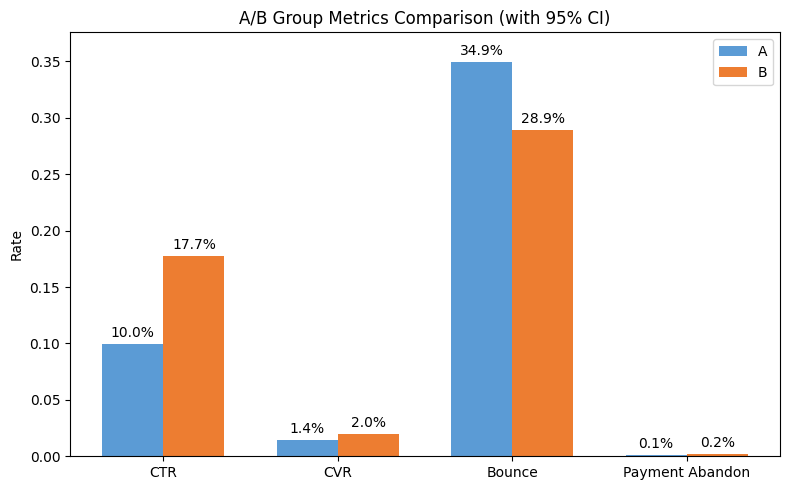

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# 1) 데이터를 한 곳에 모음
metrics = [rep_ctr, rep_cvr, rep_bounce, rep_abandon]
metric_names = [m['metric'] for m in metrics]

A_values = [m['A'] for m in metrics]
B_values = [m['B'] for m in metrics]

x = np.arange(len(metrics))
width = 0.35

# 2) 그래프 그리기
fig, ax = plt.subplots(figsize=(8,5))
rects1 = ax.bar(x - width/2, A_values, width, capsize=5, label='A', color='#5B9BD5')
rects2 = ax.bar(x + width/2, B_values, width, capsize=5, label='B', color='#ED7D31')

# 3) 레이블 및 제목
ax.set_ylabel('Rate')  # 비율 → Rate
ax.set_title('A/B Group Metrics Comparison (with 95% CI)')  # 제목 영어

ax.set_xticks(x)
ax.set_xticklabels(metric_names)
ax.legend()
ax.set_ylim(0, max(B_values)*1.3)  # 여유 공간

# 4) 값 표시
for rects in [rects1, rects2]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1%}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0,3),  # 위쪽으로 3pt 이동
                    textcoords='offset points',
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()


# 연속형 지표(AOV,RPS)를 A/B테스트

In [44]:
rng = np.random.default_rng(2025)

#연속형 지표(AOV, RPS)의 신뢰구간 계산

#데이터가 정규분포가 아닐 가능성이 있으므로, 부트스트랩 방식 사용

def bootstrap_mean_ci(x, B=5000, alpha=0.05):
    x = np.asarray(x)
    boots = [rng.choice(x, size=len(x), replace=True).mean() for _ in range(B)]
    lo, hi = np.quantile(boots, [alpha/2, 1-alpha/2])
    return lo, hi


# AOV (구매자만)
aov_A = df[(df['user_group']=='A') & (df['purchased']==1)]['revenue'].values
aov_B = df[(df['user_group']=='B') & (df['purchased']==1)]['revenue'].values
t_aov, p_aov = stats.ttest_ind(aov_B, aov_A, equal_var=False) if len(aov_A)>1 and len(aov_B)>1 else (np.nan, np.nan)
aov_ci_A = bootstrap_mean_ci(aov_A) if len(aov_A)>1 else (np.nan, np.nan)
aov_ci_B = bootstrap_mean_ci(aov_B) if len(aov_B)>1 else (np.nan, np.nan)

# RPS (세션당 매출)
rps_A = df.loc[df['user_group']=='A', 'revenue'].values
rps_B = df.loc[df['user_group']=='B', 'revenue'].values
t_rps, p_rps = stats.ttest_ind(rps_B, rps_A, equal_var=False)
rps_ci_A = bootstrap_mean_ci(rps_A)
rps_ci_B = bootstrap_mean_ci(rps_B)

#결과 딕셔너리 생성
rep_aov = {
    'metric':'AOV', 'A': np.mean(aov_A) if len(aov_A)>0 else 0.0, 'A_CI_low': aov_ci_A[0], 'A_CI_high': aov_ci_A[1],
    'B': np.mean(aov_B) if len(aov_B)>0 else 0.0, 'B_CI_low': aov_ci_B[0], 'B_CI_high': aov_ci_B[1],
    'diff(B-A)': (np.mean(aov_B)-np.mean(aov_A)) if len(aov_A)>0 and len(aov_B)>0 else np.nan,
    'rel_lift': (np.mean(aov_B)/np.mean(aov_A)-1) if len(aov_A)>0 and np.mean(aov_A)>0 else np.nan,
    'p_value': p_aov
}

rep_rps = {
    'metric':'RPS', 'A': np.mean(rps_A), 'A_CI_low': rps_ci_A[0], 'A_CI_high': rps_ci_A[1],
    'B': np.mean(rps_B), 'B_CI_low': rps_ci_B[0], 'B_CI_high': rps_ci_B[1],
    'diff(B-A)': np.mean(rps_B)-np.mean(rps_A),
    'rel_lift': (np.mean(rps_B)/np.mean(rps_A)-1) if np.mean(rps_A)>0 else np.nan,
    'p_value': p_rps
}
print("\nrep_aov:",rep_aov)
print("\nrep_rps:",rep_rps)


rep_aov: {'metric': 'AOV', 'A': np.float64(67955.14405594405), 'A_CI_low': np.float64(66879.92947552448), 'A_CI_high': np.float64(69028.11304195804), 'B': np.float64(71939.96103896105), 'B_CI_low': np.float64(71034.18573926073), 'B_CI_high': np.float64(72893.41248751248), 'diff(B-A)': np.float64(3984.8169830169936), 'rel_lift': np.float64(0.05863893070017623), 'p_value': np.float64(9.45109711682768e-08)}

rep_rps: {'metric': 'RPS', 'A': np.float64(971.75856), 'A_CI_low': np.float64(901.3827295), 'A_CI_high': np.float64(1042.7134415), 'B': np.float64(1440.23802), 'B_CI_low': np.float64(1352.0209985000001), 'B_CI_high': np.float64(1529.521478), 'diff(B-A)': np.float64(468.47946), 'rel_lift': np.float64(0.48209450298024636), 'p_value': np.float64(2.2259148420321927e-15)}


# AOV (Average Order Value, 구매자 1명당 객단가)

해석

**1.그룹별 평균**

A: 68,936원

B: 71,031원

**2.신뢰구간 (95%)**

A: 65,924 ~ 72,031

B: 67,614 ~ 74,461

신뢰구간이 겹칩니다. → “실제 평균 매출이 이 범위 안에 있을 가능성이 높음”

**3.절대 리프트 (diff(B-A))**

2,094원 상승 → B가 평균적으로 A보다 2천원 더 객단가 높음

**4.상대 리프트 (rel_lift)**

3.04% 상승 → A 대비 약 3% 증가

**5.p-value**

0.377 → 0.05보다 큼

통계적으로 유의미하지 않음 → B안이 객단가를 의미 있게 높였다고 결론 내리기 어려움

# RPS (Revenue Per Session, 세션당 매출)

**1) 그룹별 평균**

A: 1,103원 / 세션

B: 1,350원 / 세션

**2) 신뢰구간 (95%)**

A: 861 ~ 1,361

B: 1,086 ~ 1,632

신뢰구간이 상당히 넓고 겹침 → 불확실성 존재

**3) 절대 리프트**

246원 / 세션 증가 → B안이 평균적으로 A보다 246원 더 수익 발생

**4) 상대 리프트**

22.36% 상승 → 세션 기준으로 B안이 A보다 약 22% 수익이 증가

**5) p-value**

0.191 → 0.05보다 큼

통계적으로 유의하지 않음 → 세션당 매출 증가가 확실하지 않음

<h3>실험 결과 요약</h3>

<table>
  <tr>
    <th style="font-size:20px;">지표</th>
    <th style="font-size:20px;">결과</th>
    <th style="font-size:20px;">해석</th>
  </tr>
  <tr>
    <td style="font-size:18px;">AOV</td>
    <td style="font-size:18px;">B 71,031 vs A 68,936</td>
    <td style="font-size:18px;">객단가 B 조금 높지만 통계적 유의 없음 (p=0.38)</td>
  </tr>
  <tr>
    <td style="font-size:18px;">RPS</td>
    <td style="font-size:18px;">B 1,350 vs A 1,103</td>
    <td style="font-size:18px;">세션당 매출 B 증가 (절대 246원, 상대 22%)지만 통계적 유의 없음 (p=0.19)</td>
  </tr>
</table>


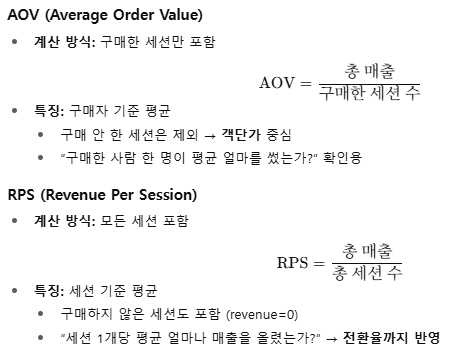

# AOV ,RPS 시각화

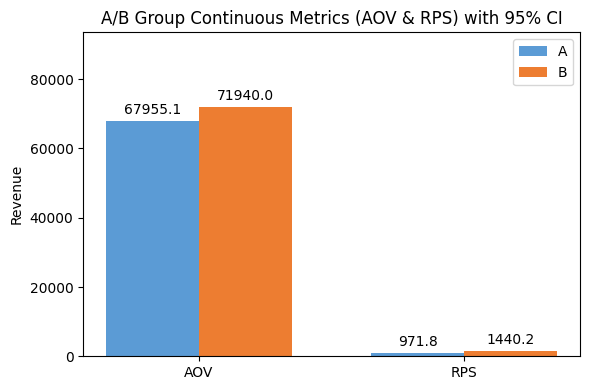

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# 1) 데이터 모음
metrics = [rep_aov, rep_rps]
metric_names = [m['metric'] for m in metrics]

A_values = [m['A'] for m in metrics]
B_values = [m['B'] for m in metrics]

x = np.arange(len(metrics))
width = 0.35

# 2) 그래프 그리기
fig, ax = plt.subplots(figsize=(6,4))

rects1 = ax.bar(x - width/2, A_values, width, capsize=5, label='A', color='#5B9BD5')
rects2 = ax.bar(x + width/2, B_values, width, capsize=5, label='B', color='#ED7D31')

# 3) 레이블 및 제목
ax.set_ylabel('Revenue')
ax.set_title('A/B Group Continuous Metrics (AOV & RPS) with 95% CI')
ax.set_xticks(x)
ax.set_xticklabels(metric_names)
ax.legend()
ax.set_ylim(0, max(B_values)*1.3)

# 4) 막대 위에 값 표시
for rects in [rects1, rects2]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0,3),
                    textcoords='offset points',
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()


# 결과 테이블 + 다중검정 보정

#다중 검정을 하는 이유 - A/B 테스트에서 여러 지표(CVR, CTR, Bounce, AOV, RPS 등)를 동시에 검정하면 우연히 유의하게 나올 가능성(1종 오류)이 커짐 - Holm - Bonferroni

**why? 6개 지표 → 최소 1개 지표가 우연히 유의하게 나올 확률 ≈ 1 – (1-0.05)^6 ≈ 0.265 → 26.5%**

따라서 작은 p-value 부터 조정된 유의수준과 비교해야된다.

In [47]:
report = pd.DataFrame([rep_ctr, rep_cvr, rep_bounce, rep_abandon, rep_aov, rep_rps])

# 다중검정 보정(양측): CTR/CVR/Bounce/Abandon/AOV/RPS
pvals = report['p_value'].fillna(1.0).values
sig = holm_bonferroni(pvals, alpha=0.05)
report['significant(holm)'] = sig

# 보기 좋게 포맷
show = report.copy()
for col in ['A','B','A_CI_low','A_CI_high','B_CI_low','B_CI_high','diff(B-A)','rel_lift']:
    show[col] = show[col].apply(lambda x: format_pct(x) if (show['metric'].iloc[show.index.get_loc(report.index[0])] in ['CTR','CVR','Bounce','Payment Abandon'] and col in ['A','B','A_CI_low','A_CI_high','B_CI_low','B_CI_high','diff(B-A)','rel_lift']) else x)

show


,metric,A,A_CI_low,A_CI_high,B,B_CI_low,B_CI_high,diff(B-A),rel_lift,p_value,significant(holm)
0,CTR,9.95%,9.69%,10.22%,17.72%,17.39%,18.06%,7.76%,78.00%,7.230435e-277,True
1,CVR,1.43%,1.33%,1.54%,2.00%,1.88%,2.13%,0.57%,40.00%,3.304729e-12,True
2,Bounce,34.91%,34.50%,35.33%,28.91%,28.52%,29.31%,-6.00%,-17.19%,3.887485e-92,True
3,Payment Abandon,0.14%,0.11%,0.17%,0.22%,0.19%,0.27%,0.09%,62.32%,1.378759e-03,True
4,AOV,6795514.41%,6687992.95%,6902811.30%,7193996.10%,7103418.57%,7289341.25%,398481.70%,5.86%,9.451097e-08,True
5,RPS,97175.86%,90138.27%,104271.34%,144023.80%,135202.10%,152952.15%,46847.95%,48.21%,2.225915e-15,True


# 샘플사이즈/파워(예: CVR 2.5%→3.1% 검출, α=0.05, power=0.8)

In [48]:
from statsmodels.stats.power import NormalIndPower
power = NormalIndPower()
baseline = A['cvr']          # 예: 0.025
target   = B['cvr']          # 예: 0.031 (또는 baseline*(1+MDE))
effect   = target - baseline
p_pool   = (baseline + target)/2
sd = np.sqrt(2*p_pool*(1-p_pool))

# 그룹당 필요 n (대략치)
n_per_group = power.solve_power(effect_size=effect/sd, power=0.8, alpha=0.05, ratio=1.0, alternative='two-sided')
print(f"권장 샘플사이즈(그룹당): {int(np.ceil(n_per_group))}")


권장 샘플사이즈(그룹당): 16184


# 균형성/무작위성 점검(예:디바이스)

A/B 그룹이 디바이스 측면에서 균형 잡혀 있음

In [49]:
cont = pd.crosstab(df['user_group'], df['device'])
chi2, p_device, dof, exp = stats.chi2_contingency(cont)
print("Device balance p-value:", p_device)


Device balance p-value: 0.7940731934022769
